In [0]:
!cp -r './drive/My Drive/AI/speedchallenge' './'

In [0]:
import os, datetime
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Load the TensorBoard notebook extension
%load_ext tensorboard

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#@title Loader code
def load_frames(train_video_path, max_frames=-1):
    videoCapture = cv2.VideoCapture(train_video_path)

    fc = int(videoCapture.get(cv2.CAP_PROP_FRAME_COUNT))
    fw = int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH))
    fh = int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    if max_frames != -1 and max_frames < fc:
        fc = max_frames

    dst_h = int(fh/2.0)
    dst_w = int(fw/2.0)
    buf = np.empty((fc, dst_h, dst_w, 3), np.dtype('uint8'))

    count = 0
    ret = True

    while count < fc and ret:
        ret, img = videoCapture.read()
        buf[count] = cv2.resize(img, dsize=(dst_w, dst_h), interpolation=cv2.INTER_CUBIC)
        count += 1

    videoCapture.release()
    return buf


def load_speeds(train_txt_path, max_frames=-1):
    with open(train_txt_path) as f:
        content = f.readlines()
        if max_frames != -1 and max_frames < len(content):
          fc = max_frames
        else:
          fc = len(content)
        speeds = [float(x.strip()) / 100.0 for x in content][:fc]

    return np.array(speeds)

def process_images(all_images):
    all_images = all_images[:, 20:-60, 5:-5, :]
    return all_images


def prepare_inputs(frames, outputs):
    indices = np.arange(len(frames) - 1)
    np.random.shuffle(indices)

    first_frames = frames[indices, :, :, :]
    second_frames = frames[indices + 1, :, :, :]

    inputs = np.concatenate([first_frames, second_frames], axis=2)

    assert inputs.shape[0] == len(first_frames), "Number of frames should be (n - 1)"
    assert inputs.shape[-1] == 3, "Number of channels should be 3."

    return inputs, outputs[indices], indices

def process_train_data(video_path, txt_path, max_frames=-1):
    all_frames = load_frames(video_path, max_frames)
    all_frames = process_images(all_frames)
    speed_list = load_speeds(txt_path, max_frames)
    all_inputs, all_outputs, indices = prepare_inputs(all_frames, speed_list)

    return all_inputs, all_outputs, indices

def unshuffle(arr, indices):
    unshuffled = np.array(arr)
    for i, j in enumerate(indices):
        unshuffled[j] = arr[i]
    return unshuffled


0.12537331


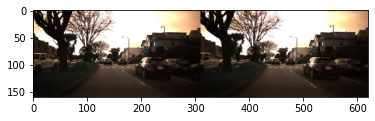

In [5]:
all_inputs, all_outputs, indices = process_train_data('./speedchallenge/train.mp4', './speedchallenge/train.txt')

print(all_outputs[1])
plt.imshow(all_inputs[1])

In [0]:
assert len(all_inputs) == len(all_outputs), 'dataset sizes should match'

dataset_size = len(all_inputs)
train_size = int(0.9 * dataset_size)

train_X = all_inputs[:train_size]
train_Y = all_outputs[:train_size]

dev_X = all_inputs[train_size:, :, :, :]
dev_Y = all_outputs[train_size:]

In [0]:
def build_model(input_shape):
    X_input = layers.Input(input_shape)
    X = layers.Lambda(lambda x: x / 255.0)(X_input)
    X = layers.BatchNormalization()(X)

    X = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu')(X)
    X = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPool2D((2, 2))(X)

    X = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.MaxPool2D((2, 2))(X)

    X = layers.Flatten()(X)
    X = layers.Dense(32, activation='relu')(X)
    X = layers.Dense(16, activation='relu')(X)
    X = layers.Dense(1)(X)

    model = models.Model(inputs=X_input, outputs=X)
    model.summary()
    return model


In [0]:
#@title Train Model

MAX_TRAIN_PARAMS = 1e8

def train_model(model, train_X, train_Y, dev_X, dev_Y, epochs=10):
  adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
  model.compile(optimizer=adam,
                loss='mean_squared_error')

  trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
  assert trainable_count < MAX_TRAIN_PARAMS, "trainable params exceeds %d. Aborting..." % MAX_TRAIN_PARAMS

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  print('Mean: train_Y: %f dev_Y: %f' % (np.mean(train_Y), np.mean(dev_Y)))
  print('Variance: train_Y: %f dev_Y: %f' % (np.var(train_Y), np.var(dev_Y)))
  print('Starting training...')
  history = model.fit(x=train_X, 
            y=train_Y,
            batch_size=32,
            epochs=epochs, 
            validation_data=(dev_X, dev_Y), 
            callbacks=[tensorboard_callback])
  
  plt.plot(history.history['loss'])
  plt.show()

In [0]:
#@title Evaluate Model

def evaluate(train_X, train_Y, dev_X, dev_Y):
  idx = int(0.8 * len(train_X))

  plt.imshow(train_X[idx])

  print('Train size:', len(train_X))
  print('Dev size:', len(dev_X))
  plot_pred(all_inputs, all_outputs, indices, 100)

def plot_pred(all_inputs, all_outputs, indices, N=1000):
  all_inputs_unshuffled = unshuffle(all_inputs, indices)
  all_outputs_unshuffled = unshuffle(all_outputs, indices)

  fig, ax = plt.subplots(figsize=(20,10))

  predicted = model.predict(all_inputs_unshuffled[:N])

  idx = int(0.8 * N)
  print('idx: %d, Output: %f, Predicted: %f' % (idx, all_outputs_unshuffled[idx], predicted[idx]))

  plt.plot(predicted)
  plt.plot(all_outputs_unshuffled[:N])

  plt.xlabel('image_index (or time since start)')
  plt.ylabel('speed')
  plt.title('Predicted vs actual on validation data')
  plt.legend(['validation speed', 'predicted speed'], loc='upper right')
  plt.show()
  plt.close()

In [0]:
def train_and_evaluate(model, train_X, train_Y, dev_X, dev_Y, epochs=10):
  train_model(model, train_X, train_Y, dev_X, dev_Y, epochs)
  evaluate(train_X, train_Y, dev_X, dev_Y)

In [19]:
model = build_model(train_X.shape[1:])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 620, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 160, 620, 3)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 160, 620, 3)       12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 158, 618, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 156, 616, 64)      18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 156, 616, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 78, 308, 64)       0   

Mean: train_Y: 0.121795 dev_Y: 0.122213
Variance: train_Y: 0.006703 dev_Y: 0.007017
Starting training...
Epoch 1/25
574/574 [==============================] - 92s 159ms/step - loss: 2.4812 - val_loss: 0.0199
Epoch 2/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0174 - val_loss: 0.0121
Epoch 3/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0107 - val_loss: 0.0070
Epoch 4/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 5/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 6/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 7/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 8/25
574/574 [==============================] - 91s 159ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/25
574/574 [==============================] - 91s 159ms/step - 

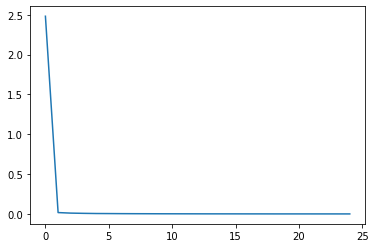

Train size: 18359
Dev size: 2040
idx: 80, Output: 0.268703, Predicted: 0.282706


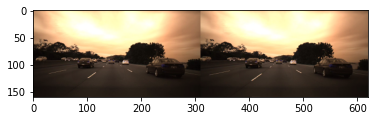

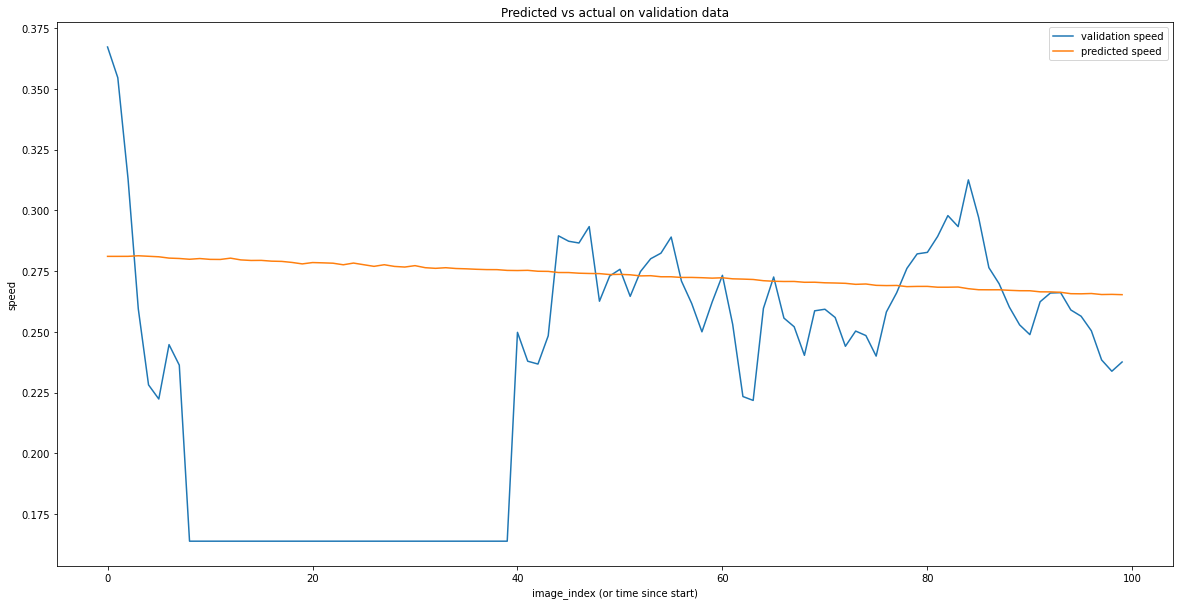

In [27]:
train_size = len(train_X)
dev_size = len(dev_X)
train_and_evaluate(model, train_X[:train_size], train_Y[:train_size], dev_X[:dev_size], dev_Y[:dev_size], 25)

idx: 16319, Output: 0.097598, Predicted: 0.103223


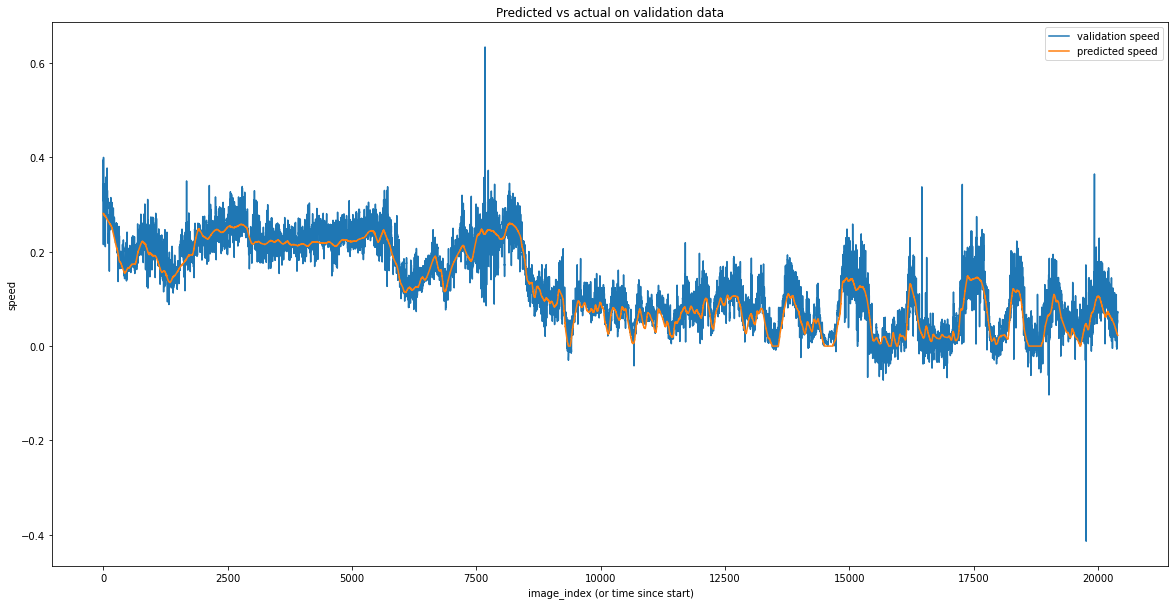

In [26]:
plot_pred(all_inputs, all_outputs, indices, len(all_inputs))

In [0]:
%tensorboard --logdir logs